In [2]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import pytesseract as tess
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
# Original dataset has 25K images
# image_folder = "./data/kaggle/imgs/"
# label_folder = "./data/kaggle/labels/"
IMG_DIR = "./data/imgs/"
LABEL_DIR = "./data/labels/"
TEST_DIR = "./data/test/"
SAMPLE_SIZE = 500

## Data processing

In [4]:
def get_image_filenames(image_folder):
    image_filenames = []
    for file in os.listdir(image_folder):
        if file.endswith(".jpg"):
            image_filenames.append(file)
        
    return image_filenames

def get_label_filenames(label_folder):
    label_filenames = []
    for file in os.listdir(label_folder):
        if file.endswith(".txt"):
            label_filenames.append(file)
        
    return label_filenames

In [5]:
all_image_filenames = get_image_filenames(IMG_DIR)
all_label_filenames = get_label_filenames(LABEL_DIR)

In [6]:
def filter_filenames(image_filenames, label_filenames, image_folder=IMG_DIR, label_folder=LABEL_DIR):
    labels_removed = []
    imgs_removed = []

    # Remove images that don't have labels, if any
    for img in image_filenames:
        if img[:-4] + ".txt" not in label_filenames:
            imgs_removed.append(img)
            
    # Remove labels that don't have images, if any
    for lbl in label_filenames:
        if lbl[:-4] + ".jpg" not in image_filenames:
            labels_removed.append(lbl)

    # Skip images that have more than one bounding box
    for lbl in label_filenames:
        with open(label_folder + lbl, "r") as file:
            if len(file.readlines()) > 1:
                labels_removed.append(lbl)
                imgs_removed.append(lbl[:-4] + ".jpg")

    # Remove images and labels that don't have a bounding box
    for lbl in label_filenames:
        with open(label_folder + lbl, "r") as file:
            if len(file.readlines()) == 0:
                labels_removed.append(lbl)
                imgs_removed.append(lbl[:-4] + ".jpg")

    # Remove images that have _jpg.rf. in their name
    for img in image_filenames:
        if "_jpg.rf." in img:
            imgs_removed.append(img)
            labels_removed.append(img[:-4] + ".txt")

                
    # Remove images and labels
    filtered_img_filenames = [img for img in image_filenames if img not in imgs_removed]
    filtered_label_filenames = [lbl for lbl in label_filenames if lbl not in labels_removed]

    # Print number of entries
    print(f"{len(image_filenames) - len(filtered_img_filenames)} of {len(image_filenames)} images removed.", )
    print(f"{len(label_filenames) - len(filtered_label_filenames)} of {len(label_filenames)} labels removed.")

    # Keep only a random sample of the data
    np.random.seed(42)
    sample_size = SAMPLE_SIZE if SAMPLE_SIZE <= len(filtered_img_filenames) else len(filtered_img_filenames)
    filtered_img_filenames = np.random.choice(filtered_img_filenames, sample_size, replace=False)
    filtered_label_filenames = [f[:-4] + ".txt" for f in filtered_img_filenames]

    # Test if all image filanames have a corresponding label filename
    assert all([f[:-4] + ".txt" in filtered_label_filenames for f in filtered_img_filenames])

    print("Final number of images:", len(filtered_img_filenames))
    print("Final number of labels:", len(filtered_label_filenames))

    return filtered_img_filenames, filtered_label_filenames

# image_filenames, label_filenames = filter_filenames(all_image_filenames, all_label_filenames)

In [7]:
# Copy and rename images and labels to a new folder
def copy_rename_files(image_filenames, label_filenames):
    new_image_folder = "./data/imgs/"
    new_label_folder = "./data/labels/"

    if not os.path.exists(new_image_folder):
        os.makedirs(new_image_folder)

    if not os.path.exists(new_label_folder):
        os.makedirs(new_label_folder)

    for i in range(len(image_filenames)):
        shutil.copy(IMG_DIR + image_filenames[i], new_image_folder + f"img_{i}.jpg")
        shutil.copy(LABEL_DIR + label_filenames[i], new_label_folder + f"img_{i}.txt")

    print("Files copied and renamed.")

# copy_rename_files(image_filenames, label_filenames)

## Load the data

In [8]:
# Read the data, expects image filenames to match label filenames, labels are YOLO format
def load_dataframe(image_folder, label_folder, filter_files=False):
    yolo_labels_dict = dict(image=[], x_center=[], y_center=[], width=[], height=[])

    if filter_files:
        _, label_filenames = filter_filenames(get_image_filenames(image_folder), get_label_filenames(label_folder), image_folder, label_folder)
    else:
        label_filenames = [f for f in os.listdir(label_folder) if f.endswith(".txt")]

    # Read the YOLO annotation files, and store the data in a dictionary
    for file in label_filenames:
        label_file = os.path.join(label_folder, file)
        with open(label_file, "r") as lf:
            for line in lf.readlines():
                parts = line.strip().split(" ")
                class_id = int(parts[0])
                if class_id != 0:
                    print("Class ID is not 0: class=", class_id)

                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                yolo_labels_dict["image"].append(file[:-4])
                yolo_labels_dict["x_center"].append(x_center)
                yolo_labels_dict["y_center"].append(y_center)
                yolo_labels_dict["width"].append(width)
                yolo_labels_dict["height"].append(height)

    # Convert the data to a pandas dataframe
    return pd.DataFrame(yolo_labels_dict)

df = load_dataframe(IMG_DIR, LABEL_DIR, filter_files=True)
df.head()

0 of 2993 images removed.
0 of 2993 labels removed.
Final number of images: 500
Final number of labels: 500


,image,x_center,y_center,width,height
0,img_1673,0.550703,0.514271,0.161875,0.214167
1,img_1144,0.683916,0.676445,0.128495,0.057500
2,img_1149,0.246367,0.631146,0.023125,0.015834
3,img_1383,0.350352,0.664843,0.033750,0.015000
4,img_2881,0.501680,0.710263,0.725625,0.513684


In [9]:
def yolo_to_voc(x,y,w,h):
    x1 = (x - w/2)
    y1 = (y - h/2)
    x2 = (x + w/2)
    y2 = (y + h/2)
    return x1, y1, x2, y2

def voc_to_yolo(x1, y1, x2, y2):
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return x, y, w, h

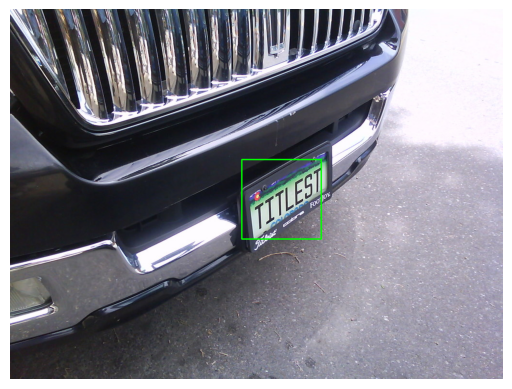

In [10]:
# Plot sample image with bounding boxes
def samplePlot(dataframe):
    row = dataframe.head(1)
    image, x, y, w, h = row.iloc[0]
    path = f"./data/imgs/{image}.jpg"
    img = cv2.imread(path)
    img_h, img_w, img_d = img.shape

    # Open CV uses (x, y) coordinates of the top-left corner and the bottom-right corner
    x1, y1, x2, y2 = yolo_to_voc(x, y, w, h)
    x1 = int(x1 * img_w)
    y1 = int(y1 * img_h)
    x2 = int(x2 * img_w)
    y2 = int(y2 * img_h)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0),2)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

samplePlot(df)

## License detection model

In [11]:
# Convert images to array with YOLO format labels
def convert_to_array(df, folder=IMG_DIR):
    data = []
    output = []

    for i in range(len(df)):
        image, x, y, h, w = df.iloc[i]
        img_path = f"{folder}{image}.jpg"

        # Preprocess the image
        img_array = img_to_array(load_img(img_path, target_size=(224, 224)))
        img_array = img_array / 255.0

        data.append(img_array)
        output.append((x,y,h,w))

    return np.array(data, dtype=np.float32), np.array(output, dtype=np.float32)


In [12]:
# Save the data in a compressed file for cloud computing
def save_split_data(X, y, filename):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    np.savez_compressed(filename, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# X, y = convert_to_array(df)
# print("Data converted to array:",X.shape, y.shape)
# save_split_data(X, y, "data.npz")
# save_split_data(X, y, "test.npz")
# print("Data saved.")

### Training
Please take a look at the 'training.py' file for the training part. It was kept on a separate script file for cloud computing.

### Predictions

In [13]:
# Load model on CPU
test_df = load_dataframe(TEST_DIR, TEST_DIR, True)
with tf.device('/CPU:0'):
    model = tf.keras.models.load_model("plate_detection.h5")

90 of 372 images removed.
91 of 373 labels removed.
Final number of images: 282
Final number of labels: 282


2024-04-10 18:56:20.038563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 18:56:20.141610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 987 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:00:05.0, compute capability: 8.6


In [14]:
test_df.head()

,image,x_center,y_center,width,height
0,08481c03daf6f35d,0.498404,0.938237,0.378143,0.121969
1,da1352ab6054a2e4,0.490184,0.657727,0.562784,0.363166
2,315aead7766727b8,0.462391,0.728912,0.228725,0.070033
3,50c37aeaf19acd5b,0.758268,0.727997,0.136779,0.130522
4,7b4e86e1c94d65de,0.934114,0.554377,0.024084,0.035171


In [36]:
# Plot and image with the bounding boxes
def plot_prediction(img_path, x1,y1,x2,y2, pred_x1, pred_y1, pred_x2, pred_y2):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0),2)
    img = cv2.rectangle(img, (pred_x1, pred_y1), (pred_x2, pred_y2), (0,255,0),2)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [29]:
# Make predictions on testing set, calculate overall model metrics
def calculate_ious(model, test_df):
    X_test, _ = convert_to_array(test_df, TEST_DIR)
    y_pred = model.predict(X_test)
    ious = []
    ious_df = pd.DataFrame(columns=["image", "x", "y", "w", "h", "px", "py", "pw", "ph", "iou", "img_w", "img_h"])

    for i in range(len(X_test)):
        image_path, x, y, w, h = test_df.iloc[i]
        path = f"{TEST_DIR}{image_path}.jpg"

        img_h, img_w, _ = cv2.imread(path).shape
        px, py, pw, ph = y_pred[i]
    
        # Calculate accuracy
        x1, y1, x2, y2 = yolo_to_voc(x*img_w, y*img_h, w*img_w, h*img_h)
        x1_pred, y1_pred, x2_pred, y2_pred = yolo_to_voc(px*img_w, py*img_h, pw*img_w, ph*img_h)

        # Calculate IOU
        xA = max(x1, x1_pred)
        yA = max(y1, y1_pred)
        xB = min(x2, x2_pred)
        yB = min(y2, y2_pred)

        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (x2 - x1 + 1) * (y2 - y1 + 1)
        boxBArea = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        ious.append(iou)

        ious_df.loc[i] = [image_path, x, y, w, h, px, py, pw, ph, iou, img_w, img_h]

    return ious, ious_df

ious, ious_df = calculate_ious(model, test_df)

9/9 [==============================] - 3s 332ms/step


In [48]:
# Plot the results of a sample prediction
def sample_prediction(dataframe, folder):
    row = dataframe.sample(1)
    image_path, x, y, w, h, p_x, p_y, p_w, p_h, iou, img_w, img_h = row.iloc[0]

    print("Loading image:", image_path)
    path = f"{folder}{image_path}.jpg"
    
    # Format string to display the coordinates, rounded to 3 decimals
    print(f"Predicted coordinates: x={p_x:.3f}, y={p_y:.3f}, w={p_w:.3f}, h={p_h:.3f}")
    print(f"Actual coordinates: x={x:.3f}, y={y:.3f}, w={w:.3f}, h={h:.3f}")
    print("IOU:", iou)
    
    # Denormalize the coordinates
    p_x1, p_y1, p_x2, p_y2 = yolo_to_voc(p_x * img_w, p_y * img_h, p_w * img_w, p_h * img_h)
    x1, y1, x2, y2 = yolo_to_voc(x * img_w, y * img_h, w * img_w, h * img_h)

    # Convert to integers
    p_x1, p_y1, p_x2, p_y2 = int(p_x1), int(p_y1), int(p_x2), int(p_y2)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    # Plot the image with the bounding boxes
    plot_prediction(path, x1, y1, x2, y2, p_x1, p_y1, p_x2, p_y2)

Good prediction

Loading image: 74ee6d1b58ae2e70
Predicted coordinates: x=0.503, y=0.600, w=0.157, h=0.059
Actual coordinates: x=0.505, y=0.596, w=0.158, h=0.048
IOU: 0.7995786345086884


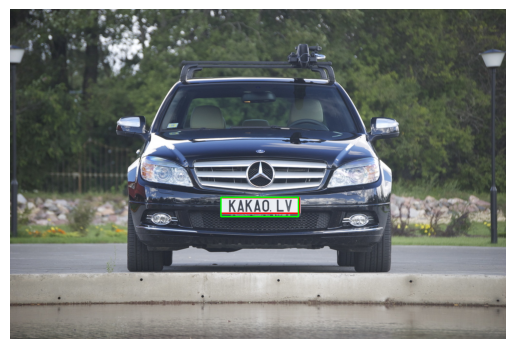

In [49]:
# Plot a good prediction
sample_prediction(ious_df[ious_df["iou"] > 0.5], TEST_DIR)

Bad prediction, IOU <= 0.1

Loading image: 26192da5ce2afa62
Predicted coordinates: x=0.354, y=0.168, w=0.099, h=0.046
Actual coordinates: x=0.365, y=0.127, w=0.054, h=0.052
IOU: 0.0669608017532046


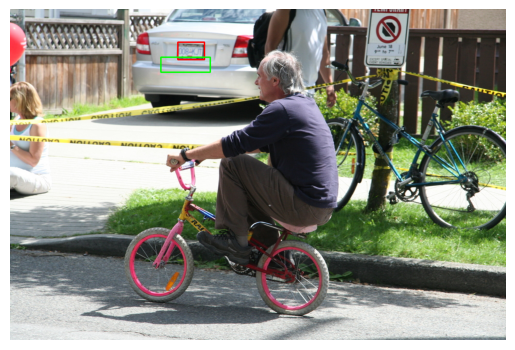

In [50]:
sample_prediction(ious_df[ious_df["iou"] <= 0.1], TEST_DIR)

### Metrics

Mean Average Precision: 0.5726511509005258


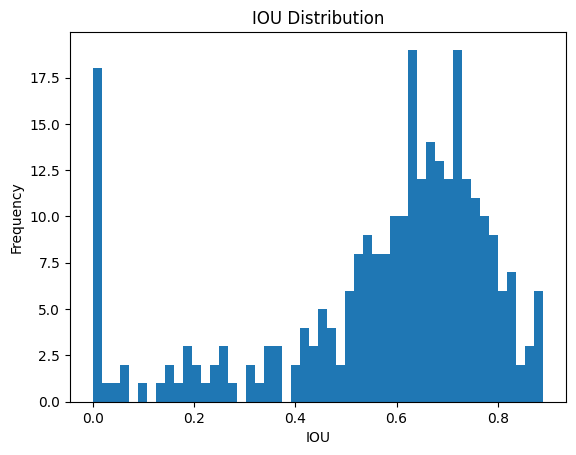

In [19]:
def plot_iou_distribution(ious):
    # Print mean average precision
    mAP = np.mean(ious)
    print("Mean Average Precision:", mAP)

    # Plot ious
    plt.hist(ious, bins=50)
    plt.xlabel("IOU")
    plt.ylabel("Frequency")
    plt.title("IOU Distribution")
    plt.show()
    
plot_iou_distribution(ious)

In [ ]:
def parse_history_file():
    epochs = 180
    metrics = 4
    # Sample epoch display lines
    # Epoch 2/180
    # 150/150 [==============================] - 29s 193ms/step - loss: 0.0082 - accuracy: 0.8555 - val_loss: 0.0127 - val_accuracy: 0.8230

    with open("history.txt", "r") as f:
        lines = f.readlines()
        history = np.zeros((epochs, metrics))
        loss = []
        val_loss = []
        accuracy = []
        val_accuracy = []

        for line in lines:
            if "loss:" in line:
                line = line.strip().split(" ")
                loss.append(float(line[7]))
                accuracy.append(float(line[10]))
                val_loss.append(float(line[13]))
                val_accuracy.append(float(line[16]))

        history[:, 0] = loss
        history[:, 1] = val_loss
        history[:, 2] = accuracy
        history[:, 3] = val_accuracy

        return history

history = parse_history_file()

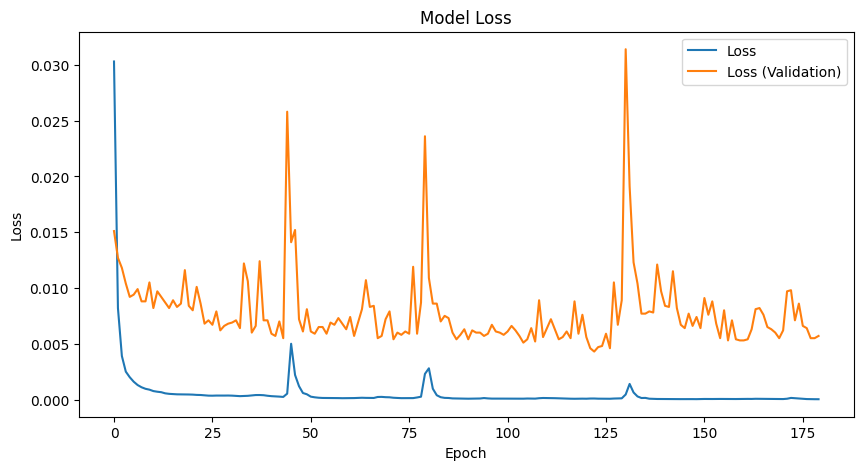

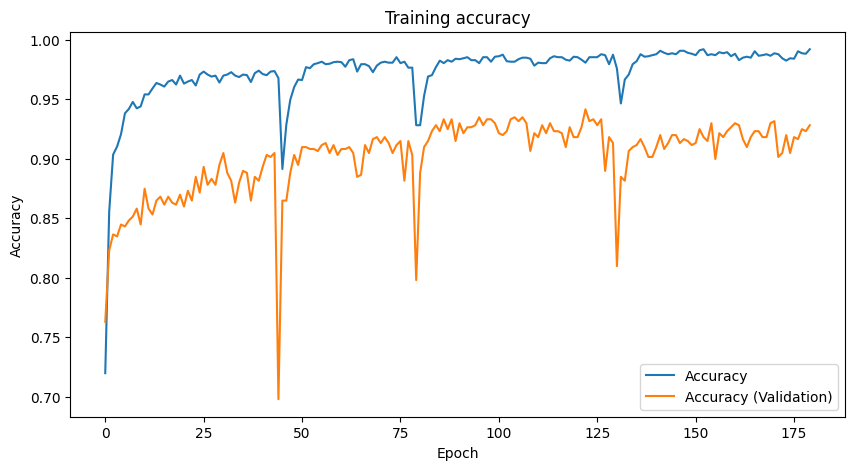

In [20]:
def plot_model_loss_history(history):
    epochs = len(history)
    plt.figure(figsize=(10, 5))
    plt.plot(history[:, 0], label="Loss")
    plt.plot(history[:, 1], label="Loss (Validation)")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

def plot_model_accuracy_history(history):
    epochs = len(history)
    plt.figure(figsize=(10, 5))
    plt.plot(history[:, 2], label="Accuracy")
    plt.plot(history[:, 3], label="Accuracy (Validation)")
    plt.title("Training accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()


plot_model_loss_history(history)
plot_model_accuracy_history(history)

In [21]:
def precision_recall_curve(y_true, pred_scores, thresholds):
    precisions = []
    recalls = []

    for t in thresholds:
        tp = 0
        fp = 0
        fn = 0

        for i in range(len(y_true)):
            if pred_scores[i] >= t:
                if y_true[i] == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if y_true[i] == 1:
                    fn += 1

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

def plot_precision_recall_curve(y_true, pred_scores, thresholds):
    precisions, recalls = precision_recall_curve(y_true, pred_scores, thresholds)
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

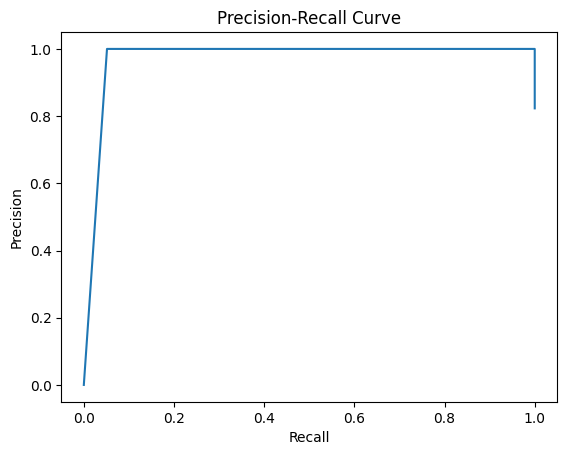

In [52]:
# Calculate precision-recall curve
thresholds = np.arange(0.1, 0.95, 0.05)
y_true = ious_df["iou"] > 0.5
plot_precision_recall_curve(y_true, ious, thresholds)